In [ ]:
# First Cell - Install required packages
!pip install easyocr
!pip install opencv-python-headless
!pip install pandas openpyxl Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 20.0 MB/s eta 0:00:00


Upload your attendance image...


Saving WhatsApp Image 2024-12-18 at 15.36.42_31cfc60b.jpg to WhatsApp Image 2024-12-18 at 15.36.42_31cfc60b.jpg
Initializing EasyOCR reader...
Preprocessing image...


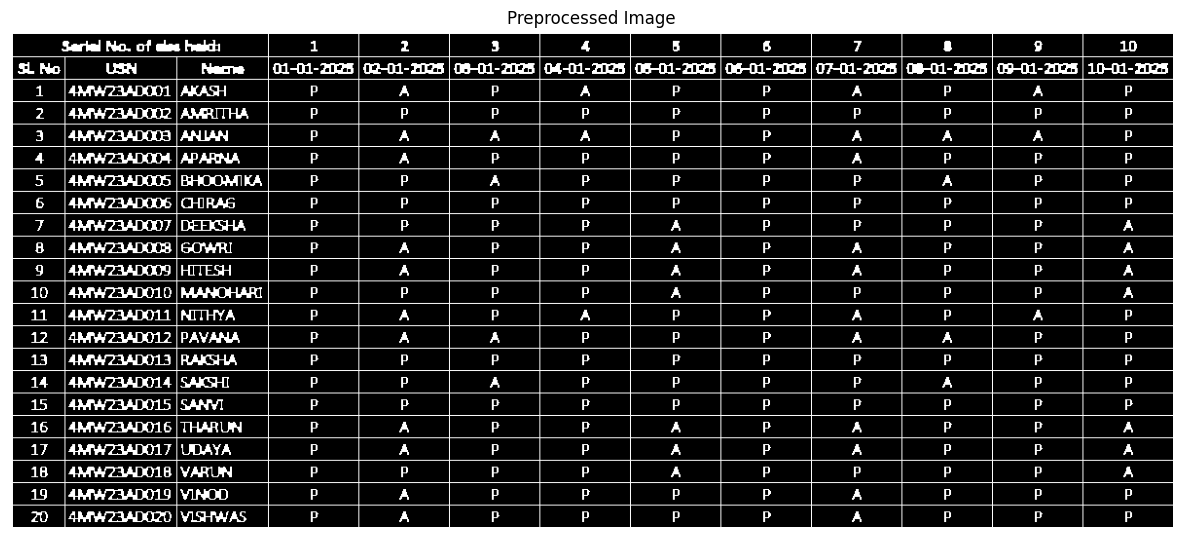

Detecting table structure...


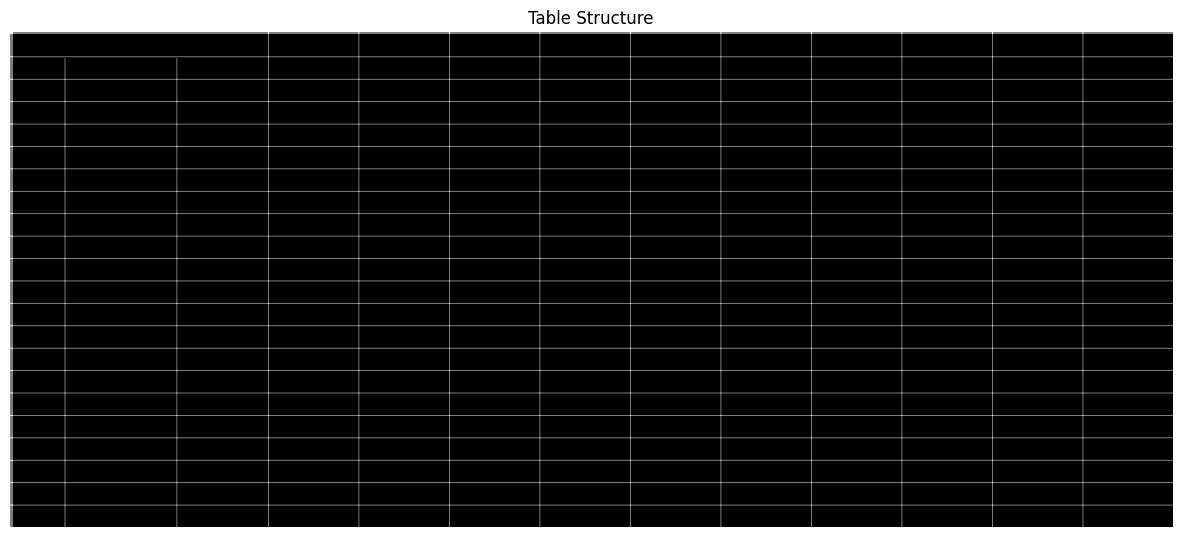

Extracting table data...
Converting to Excel...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Attendance data successfully saved to Excel!


In [ ]:
# Import libraries
import easyocr
import cv2
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

# Initialize EasyOCR Reader
def initialize_reader():
    """Initialize the EasyOCR reader"""
    print("Initializing EasyOCR reader...")
    return easyocr.Reader(['en'], gpu=True)

# Display Image
def show_image(image, title="Image"):
    """Display the image for debugging purposes"""
    plt.figure(figsize=(15, 10))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preprocess the Image
def preprocess_image(image_path):
    """Preprocess the image to enhance table extraction"""
    # Read the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )

    # Noise removal
    kernel = np.ones((2, 2), np.uint8)
    clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    return clean

# Detect Table Structure
def detect_table(image):
    """Detect horizontal and vertical lines to extract table structure"""
    # Define kernels for detecting lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 30))

    # Detect horizontal and vertical lines
    horizontal_lines = cv2.erode(image, horizontal_kernel, iterations=2)
    horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=2)

    vertical_lines = cv2.erode(image, vertical_kernel, iterations=2)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=2)

    # Combine lines
    table_structure = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0.0)

    return table_structure

# Extract Cells and Read Text
def extract_cells_and_text(image, table_image, reader):
    """Extract individual cells and read text using OCR"""
    # Find contours from the table structure
    contours, _ = cv2.findContours(table_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours top-to-bottom, left-to-right
    contours = sorted(contours, key=lambda ctr: (cv2.boundingRect(ctr)[1], cv2.boundingRect(ctr)[0]))

    cell_data = []  # Store extracted text row by row
    current_row_y = -1
    row = []

    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)

        # Ignore small noise
        if w < 20 or h < 20:
            continue

        # Extract the cell ROI
        cell_img = image[y:y+h, x:x+w]

        # Read text using EasyOCR
        text = reader.readtext(cell_img, detail=0)
        cell_text = ' '.join(text).strip() if text else ''

        # Detect new rows by comparing Y-coordinate
        if current_row_y == -1 or abs(y - current_row_y) > 20:
            if row:  # Save the previous row
                cell_data.append(row)
            row = []
            current_row_y = y

        row.append(cell_text)

    if row:  # Save the last row
        cell_data.append(row)

    return cell_data

# Main Function
def main():
    print("Upload your attendance image...")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    try:
        # Initialize OCR Reader
        reader = initialize_reader()

        # Preprocess Image
        print("Preprocessing image...")
        preprocessed_image = preprocess_image(filename)
        show_image(preprocessed_image, "Preprocessed Image")

        # Detect Table Structure
        print("Detecting table structure...")
        table_structure = detect_table(preprocessed_image)
        show_image(table_structure, "Table Structure")

        # Extract Cells and Read Text
        print("Extracting table data...")
        raw_data = extract_cells_and_text(preprocessed_image, table_structure, reader)

        # Convert to DataFrame and Save to Excel
        print("Converting to Excel...")
        columns = ['Sl. No', 'USN', 'Name', '01-01-2025', '02-01-2025',
                   '03-01-2025', '04-01-2025', '05-01-2025']

        df = pd.DataFrame(raw_data, columns=columns[:len(raw_data[0])])

        # Save to Excel
        output_file = 'attendance_output.xlsx'
        df.to_excel(output_file, index=False)
        files.download(output_file)

        print("Attendance data successfully saved to Excel!")

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the Script
if __name__ == "__main__":
    main()


Upload the attendance image...


Saving WhatsApp Image 2024-12-18 at 15.36.36_154aec5d.jpg to WhatsApp Image 2024-12-18 at 15.36.36_154aec5d (1).jpg
Initializing OCR...
Preprocessing the image...


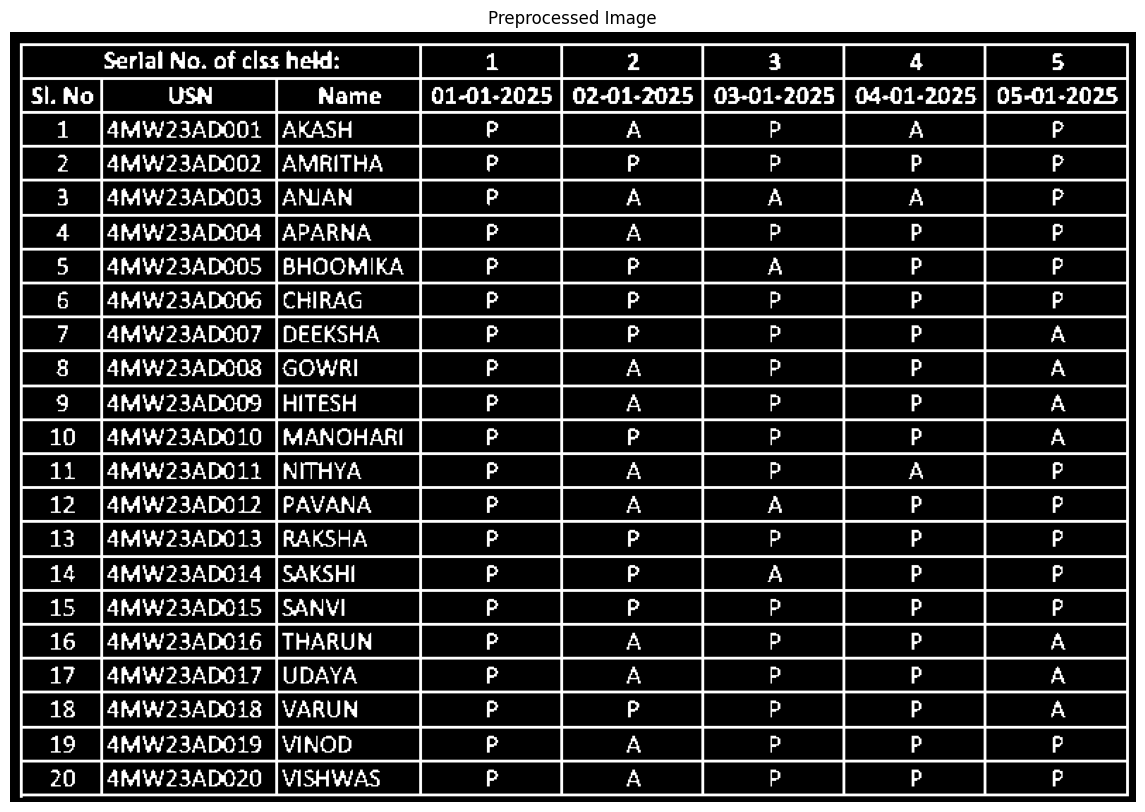

Detecting table structure...


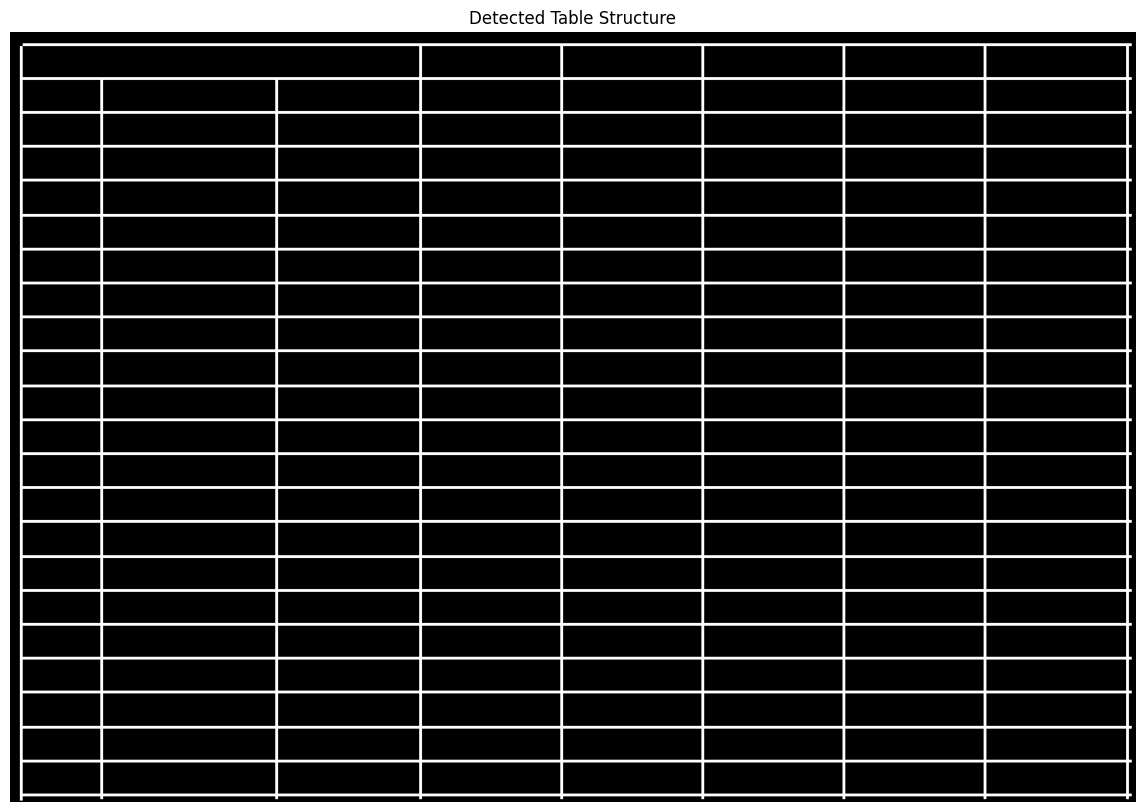

Extracting table data...
Saving to Excel...
File saved: attendance_output.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import libraries
import easyocr
import cv2
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

# Initialize EasyOCR Reader
def initialize_reader():
    print("Initializing OCR...")
    return easyocr.Reader(['en'], gpu=True)

# Display Image
def show_image(image, title="Image"):
    plt.figure(figsize=(15, 10))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preprocess Image for Table Extraction
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary threshold
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Denoise with morphological closing
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    return cleaned, image

# Detect Table Rows and Columns
def detect_table_structure(thresh_image):
    # Horizontal and vertical kernel for lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))

    # Detect lines
    horizontal_lines = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    vertical_lines = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # Combine the two lines
    table_lines = cv2.add(horizontal_lines, vertical_lines)
    return table_lines

# Extract Cells and Read Text
def extract_cells_and_text(original_image, table_lines, reader):
    # Find table cell contours
    contours, _ = cv2.findContours(table_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours top-to-bottom, left-to-right
    contours = sorted(contours, key=lambda ctr: (cv2.boundingRect(ctr)[1], cv2.boundingRect(ctr)[0]))

    row_cells = {}
    current_row_y = -1
    row_index = 0

    # Extract cell text
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)

        # Skip small cells
        if w < 30 or h < 20:
            continue

        # New row detection
        if current_row_y == -1 or abs(y - current_row_y) > 10:
            row_index += 1
            row_cells[row_index] = []
            current_row_y = y

        # Crop cell image
        cell_img = original_image[y:y+h, x:x+w]
        text = reader.readtext(cell_img, detail=0)
        cell_text = ' '.join(text).strip() if text else ""

        # Append to row
        row_cells[row_index].append(cell_text)

    return row_cells

# Convert Table Data to Excel
def save_to_excel(table_data):
    # Define correct column headers
    headers = ['Sl. No', 'USN', 'Name', '01-01-2025', '02-01-2025',
               '03-01-2025', '04-01-2025', '05-01-2025']

    # Clean and prepare table rows
    data_rows = [row for row in table_data.values() if len(row) == len(headers)]

    # Convert to DataFrame
    df = pd.DataFrame(data_rows, columns=headers)

    # Save as Excel
    output_file = 'attendance_output.xlsx'
    df.to_excel(output_file, index=False)
    print(f"File saved: {output_file}")
    files.download(output_file)

# Main Function
def main():
    print("Upload the attendance image...")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    try:
        # Initialize EasyOCR
        reader = initialize_reader()

        # Preprocess Image
        print("Preprocessing the image...")
        preprocessed_image, original_image = preprocess_image(filename)
        show_image(preprocessed_image, "Preprocessed Image")

        # Detect Table Lines
        print("Detecting table structure...")
        table_structure = detect_table_structure(preprocessed_image)
        show_image(table_structure, "Detected Table Structure")

        # Extract Cells and Text
        print("Extracting table data...")
        table_data = extract_cells_and_text(original_image, table_structure, reader)

        # Convert and Save Data to Excel
        print("Saving to Excel...")
        save_to_excel(table_data)

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the Script
if __name__ == "__main__":
    main()
